In [155]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt
import time, os, sys
from tqdm import tqdm

In [156]:
from utils.basic_utils import *
from utils.pricing import get_symbol_pricing, roll_vol, max_draw_pull, shorten_name
from utils.pricing import load_px_close, get_return_intervals, to_index_form, eq_wgt_indices
from utils.fundamental import best_performers
from utils.TechnicalDS import TechnicalDS
from utils.MacroDS import MacroDS
from utils.BaseDS import BaseDS

In [115]:
# get latest pricing file from inferece server
px_close_ds = 'universe-px-vol-ds.h5'
tmp_path = '../tmp/'
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

universe-px-vol-ds.h5                          16%   19MB   2.7MB/s   00:35 ETA^C


### Macro dataset

In [128]:
macro_ds = MacroDS(
    path='../tmp/', fname='universe-px-vol-ds.h5', 
    load_ds=True, invert_list=['EURUSD=X', 'GBPUSD=X'], include_list=['^VIX'])
y_col = f'{macro_ds.bench}{macro_ds.ycol_name}'

Target date: 2019-05-23
Loading file quote/csv/2019-05-23
Loading file summary-categories/assetProfile
OCLHV dataframes
Inverting instruments
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Ranked returns dataframes
Forward return dataframe


In [129]:
benchSL, sectorSL, riskSL, rateSL, bondSL, commSL, currSL = \
    (macro_ds.universe_dict[x] 
     for x in ('benchmarks', 'sectors', 'risk', 'rates', 'bonds', 'commodities', 'currencies'))

keep_bench = excl(benchSL, ['^STOXX50E', '^AXJO'])
keep_fx = excl(currSL, ['HKD=X', 'MXN=X', 'AUDUSD=X', 'NZDUSD=X', 'TWD=X', 'CLP=X', 'KRW=X'])
keep_sect = excl(sectorSL, ['SPY', 'QQQ', 'DIA', 'IWM', 'XLC', 'XLRE'])
keep_bonds = ['LQD', 'HYG']

symbols_list = riskSL + keep_bench + keep_sect + rateSL + keep_fx + keep_bonds

In [130]:
df = macro_ds.stitch_instruments(symbols=symbols_list, name=True, axis=1)

In [132]:
# clean up empty columns
empty_cols = df.iloc[-1].loc[df.iloc[-1].isna()].index
remove_cols = excl(empty_cols, [y_col])
df.drop(columns=remove_cols, inplace=True)
df.shape

(3775, 696)

In [146]:
cut_range = macro_ds.return_intervals(tresholds=[0.3, 0.85])
TechnicalDS.labelize_ycol(
    df, y_col, cut_range, macro_ds.forward_return_labels)

(-inf, -0.15687636852264397, -0.03605863650639852, 0.04544478336970012, 0.12055287837982177, inf)
long       0.414506
neutral    0.300055
short      0.135411
bull       0.113072
bear       0.036955
Name: ^GSPCfwdRet120, dtype: float64


### Micro dataset

In [157]:
tech_ds = TechnicalDS(path='../tmp/', fname='universe-px-vol-ds.h5', load_ds=True, )

Target date: 2019-05-23
Loading file quote/csv/2019-05-23
Loading file summary-categories/assetProfile
251 companies above 3.1x in the last 7.0 years
Sectors: 11, Industries: 136


In [158]:
tech_ds.create_base_frames()

OCLHV dataframes
Inverting instruments
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Ranked returns dataframes
Forward return dataframe


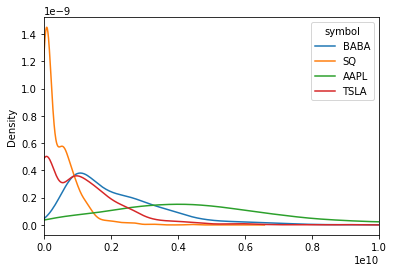

In [165]:
# Pending: how to factor in size amongst companies?
tech_ds.dollar_value_df[['BABA', 'SQ', 'AAPL', 'TSLA']].plot.kde(xlim=(0, 1e10))

#### Company level checks

In [204]:
%%time
symbol_feats = tech_ds.technical_transforms('AAPL')
df = symbol_feats
print(symbol_feats.shape)

(3775, 20)
CPU times: user 21.9 ms, sys: 1.35 ms, total: 23.3 ms
Wall time: 22.5 ms


In [205]:
cut_range = tech_ds.return_intervals(tresholds=[0.6, 0.8])

Treshold distributions: [ -inf -0.22 -0.13  0.17  0.27   inf]


In [206]:
TechnicalDS.discretize_returns(
    symbol_feats[tech_ds.ycol_name], cut_range, 
    tech_ds.forward_return_labels).head()

storeDate
2004-06-15    bull
2004-06-16    bull
2004-06-17    bull
2004-06-18    bull
2004-06-21    bull
Name: fwdRet120, dtype: category
Categories (5, object): [bear < short < neutral < long < bull]

In [208]:
df[tech_ds.ycol_name].head()

storeDate
2004-06-15    bull
2004-06-16    bull
2004-06-17    bull
2004-06-18    bull
2004-06-21    bull
Name: fwdRet120, dtype: object

In [207]:
TechnicalDS.labelize_ycol(
    df, tech_ds.ycol_name, 
    cut_range, tech_ds.forward_return_labels)

neutral    0.374242
bull       0.283508
long       0.220353
short      0.066189
bear       0.055709
Name: fwdRet120, dtype: float64


In [209]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PctChg1,3626,NaN,NaN,NaN,0.00146925,0.0208199,-0.179195,-0.00843056,0.00100827,0.0117446,0.13905
PctChg20,3620,NaN,NaN,NaN,0.0303869,0.0951062,-0.41867,-0.0252798,0.0288471,0.0884511,0.42522
PctChg50,3590,NaN,NaN,NaN,0.0799565,0.170886,-0.475987,-0.0173544,0.0723613,0.168484,0.842757
PctChg200,3440,NaN,NaN,NaN,0.327955,0.404112,-0.553622,0.0925568,0.301512,0.544356,2.07746
IntraDayChg,3626,NaN,NaN,NaN,-4.28677e-06,0.0172682,-0.120047,-0.00868631,0.00032401,0.00894471,0.129522
OpenGap,3626,NaN,NaN,NaN,0.00148963,0.0129132,-0.124968,-0.00336216,0.00134912,0.00595603,0.126802
Pct50MA,3591,NaN,NaN,NaN,1.03363,0.0902097,0.592184,0.98393,1.03349,1.08612,1.41899
Pct200MA,3441,NaN,NaN,NaN,1.1236,0.185663,0.546681,1.03845,1.13764,1.22319,1.70129
Pct52WH,3389,NaN,NaN,NaN,0.882602,0.13407,0.402792,0.829887,0.935568,0.981977,1
Pct52WL,3389,NaN,NaN,NaN,1.60965,0.421893,1,1.30666,1.52903,1.78833,3.10518


In [210]:
%%time
# stitch for all companies
companies_feats = tech_ds.stitch_instruments()
print(companies_feats.shape)

(947525, 23)
CPU times: user 6.45 s, sys: 155 ms, total: 6.61 s
Wall time: 6.61 s


In [211]:
cut_range = tech_ds.return_intervals(tresholds=[0.6, 0.8])
df = companies_feats
TechnicalDS.labelize_ycol(
    df, tech_ds.ycol_name, 
    cut_range, tech_ds.forward_return_labels)

Treshold distributions: [ -inf -0.22 -0.13  0.17  0.27   inf]
neutral    0.536774
bull       0.167520
long       0.155720
bear       0.072364
short      0.067621
Name: fwdRet120, dtype: float64


In [212]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PctChg1,849896,NaN,NaN,NaN,0.000811022,0.0244806,-0.629504,-0.00951089,0.000554085,0.0107665,1.65
PctChg20,848390,NaN,NaN,NaN,0.015447,0.103263,-0.800615,-0.0362249,0.014881,0.064726,4.04651
PctChg50,840860,NaN,NaN,NaN,0.0398022,0.164385,-0.833095,-0.045875,0.03773,0.119403,4.9375
PctChg200,803210,NaN,NaN,NaN,0.167151,0.378376,-0.931615,-0.035997,0.138426,0.318723,7.2449
IntraDayChg,849851,NaN,NaN,NaN,0.00051806,0.0212076,-0.485249,-0.00883239,0.000376935,0.00968451,1.33824
OpenGap,849823,NaN,NaN,NaN,0.000300418,0.0127366,-0.547434,-0.0036101,0,0.00418574,0.674058
Pct50MA,841070,NaN,NaN,NaN,1.01489,0.0903311,0.220159,0.970593,1.01863,1.06199,4.75252
Pct200MA,803441,NaN,NaN,NaN,1.06159,0.180848,0.111977,0.968902,1.0666,1.15561,3.97873
Pct52WH,790399,NaN,NaN,NaN,0.86162,0.151289,0.0607885,0.803053,0.91341,0.972301,1
Pct52WL,790399,NaN,NaN,NaN,1.46087,0.482536,1,1.19522,1.34436,1.56547,10.3657


#### Full group dataset

In [214]:
%%time
co_groups_df = tech_ds.stitch_companies_groups()
df = co_groups_df
print(co_groups_df.shape)

Dataset columns: Index(['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'IntraDayChg',
       'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH', 'Pct52WL', 'PctVol10DA',
       'PctVol50DA', 'PctDV10DA', 'PctDV50DA', 'RollRealVol30', 'PctChgStds1',
       'PctChgStds20', 'PctChgStds50', 'PctChgStds200', 'PerfRank20',
       'PerfRank50', 'PerfRank200', 'fwdRet120', '50StdsAll', '50StdsSect',
       '50StdsInd', '200StdsAll', '200StdsSect', '200StdsInd', 'pctGt50MAAll',
       'pctGt50MASect', 'pctGt50MAInd', 'pctGt200MAAll', 'pctGt200MASect',
       'pctGt200MAInd', 'pctPosStdsAll', 'pctPosStdsSect', 'pctPosStdsInd',
       'pctNegStdsAll', 'pctNegStdsSect', 'pctNegStdsInd', 'PerfRank20All',
       'PerfRank20Sect', 'PerfRank20Ind', 'PerfRank50All', 'PerfRank50Sect',
       'PerfRank50Ind', 'PerfRank200All', 'PerfRank200Sect', 'PerfRank200Ind',
       'delta50All', 'delta50Sect', 'delta50Ind', 'detlta200All',
       'detlta200Sect', 'detlta200Ind'],
      dtype='object')
Dataset shape: (9475

In [215]:
cut_range = tech_ds.return_intervals(tresholds=[0.6, 0.8])
TechnicalDS.labelize_ycol(
    df, tech_ds.ycol_name, 
    cut_range, tech_ds.forward_return_labels)

Treshold distributions: [ -inf -0.22 -0.13  0.17  0.27   inf]
neutral    0.536774
bull       0.167520
long       0.155720
bear       0.072364
short      0.067621
Name: fwdRet120, dtype: float64


In [216]:
co_groups_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PctChg1,849896,NaN,NaN,NaN,0.000811022,0.0244806,-0.629504,-0.00951089,0.000554085,0.0107665,1.65
PctChg20,848390,NaN,NaN,NaN,0.015447,0.103263,-0.800615,-0.0362249,0.014881,0.064726,4.04651
PctChg50,840860,NaN,NaN,NaN,0.0398022,0.164385,-0.833095,-0.045875,0.03773,0.119403,4.9375
PctChg200,803210,NaN,NaN,NaN,0.167151,0.378376,-0.931615,-0.035997,0.138426,0.318723,7.2449
IntraDayChg,849851,NaN,NaN,NaN,0.00051806,0.0212076,-0.485249,-0.00883239,0.000376935,0.00968451,1.33824
OpenGap,849823,NaN,NaN,NaN,0.000300418,0.0127366,-0.547434,-0.0036101,0,0.00418574,0.674058
Pct50MA,841070,NaN,NaN,NaN,1.01489,0.0903311,0.220159,0.970593,1.01863,1.06199,4.75252
Pct200MA,803441,NaN,NaN,NaN,1.06159,0.180848,0.111977,0.968902,1.0666,1.15561,3.97873
Pct52WH,790399,NaN,NaN,NaN,0.86162,0.151289,0.0607885,0.803053,0.91341,0.972301,1
Pct52WL,790399,NaN,NaN,NaN,1.46087,0.482536,1,1.19522,1.34436,1.56547,10.3657


### Functional experiments

In [2]:
# context data
bench = '^GSPC'
y_col = 'fwdReturn'
tickers = excl(config['companies'], [])

In [3]:
# get latest pricing file from inferece server
# px_close_ds = context['px_close']
# tmp_path = context['tmp_path']
# os.makedirs(tmp_path, exist_ok=True)
# !scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

In [19]:
# Quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

companies = config['companies']

quotes = load_csvs('quote_consol', [tgt_date])
quotes = quotes.loc[quotes.symbol.isin(equity_symbols)]
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile = profile.loc[profile.symbol.isin(equity_symbols)]
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-20
Loading file quote/csv/2019-05-20
Loading file summary-categories/assetProfile


In [21]:
def load_px_vol_ds(path, fname, load_ds=True):
    """ 
    Refresh price and volume daily, 
    used by most models with technical stats without refreshing 
    """
    if os.path.isfile(path + fname) and load_ds: 
        px_vol_ds = pd.read_hdf(path + fname, 'px_vol_df')
    else:
        # file does not exist, refreshes full dataset
        px_vol_ds = get_universe_px_vol(UNIVERSE)
        num_cols = numeric_cols(px_vol_ds)
        px_vol_ds.loc[:, num_cols] = px_vol_ds[num_cols].astype(np.float32)
        os.makedirs(path, exist_ok=True)
        px_vol_ds.to_hdf(path + fname, 'px_vol_df')
#     px_vol_ds.index = px_close.index.date
    return px_vol_ds

#### Get universe OCHL+Vol dataset

In [22]:
%%time
px_vol_df = load_px_vol_ds('../tmp/', 'universe-px-vol-ds.h5', True)

CPU times: user 63.8 ms, sys: 71.7 ms, total: 135 ms
Wall time: 135 ms


In [20]:
# load stored pricing
px_close = load_px_close('../tmp/', 'universe-px-ds', True).drop_duplicates()
print('px_close.info()', px_close.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4673 entries, 2004-05-19 to 2019-05-20
Columns: 1278 entries, 0700.HK to KRW=X
dtypes: float32(1278)
memory usage: 22.8+ MB
px_close.info() None


In [23]:
# Compare old way and new way

In [24]:
compare = 'companies'
print(f'{px_close[config[compare]].shape}')
# px_close[config[compare]].tail()

(4673, 1199)


In [25]:
print(f'{px_vol_df["close"][config[compare]].shape}')
# px_vol_df['close'][config[compare]].tail()

(4674, 1199)


#### Create raw datasets

In [176]:
universe_key = '^ALL'
symbol = 'AAPL'
look_ahead = 120;
roll_vol_days = 30; days = 252*7; quantile = 0.75
invert_tickers = ['EURUSD=X', 'GBPUSD=X']

clean_px = px_vol_df['close'].dropna(subset=[bench])
tickers = list(best_performers(clean_px, companies, days, quantile).index)
sample_symbols = np.random.choice(tickers, 3)

251 companies above 3.007x in the last 7.0 years


In [463]:
%%time
sectors = profile.loc[profile.symbol.isin(companies)].sector.unique()
industries = profile.loc[profile.symbol.isin(companies)].industry.unique()
print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')

Sectors: 11, Industries: 136
CPU times: user 2.4 ms, sys: 487 µs, total: 2.89 ms
Wall time: 2.49 ms


In [109]:
def dict_by_profile_column(profile, tickers, desc_col, subset):
    """ Maps companies to a descriptive column from profile """
    return {
        shorten_name(x):
        list(profile.loc[profile.index.isin(tickers) & profile[desc_col].isin([x]),:].index) 
        for x in subset
    }
    
sector_dict = dict_by_profile_column(profile, tickers, 'sector', sectors)
ind_dict = dict_by_profile_column(profile, tickers, 'industry', industries)

In [111]:
def max_draw(xs):
    l_dd = np.argmax(np.maximum.accumulate(xs) - xs)
    h_dd = np.argmax(np.array(xs[:l_dd]))
    return xs[l_dd]/xs[h_dd]-1

def max_pull(xs):
    h_p = np.argmax(xs - np.minimum.accumulate(xs))
    l_p = np.argmin(np.array(xs[:h_p]))
    return xs[h_p]/xs[l_p]-1

def sign_compare(x, y):
    x_abs = np.abs(x); res = x_abs // y
    return (res * np.sign(x))

#### Generic transformations (any security)

In [179]:
%%time
# price and volume base dataframes
# adjusted for SP500 trading days
# need to take into account instruments with inverted price (FX)

pct_chg_keys = [1, 20, 50, 200]
active_keys = pct_chg_keys[1:]

print('OCLHV dataframes')
close_df = px_vol_df['close'].dropna(subset=[bench])
open_df = px_vol_df['open'].dropna(subset=[bench])
low_df = px_vol_df['low'].dropna(subset=[bench])
high_df = px_vol_df['high'].dropna(subset=[bench])

# inverted securities before transforms
for df in (close_df, open_df, low_df, high_df):
    df[invert_tickers] = 1/df[invert_tickers]

vol_df = px_vol_df['volume'].dropna(subset=[bench]) # relative to 10, 60 day average
dollar_value_df = close_df * vol_df # relative to 10, 60 day average

print('Change dataframes')
close_1d_shift_df = close_df.shift(1) # closed shifted 1 day for calcs
close_1d_chg_df = close_df - close_1d_shift_df # 1 day change
pct_chg_df_dict = {x: close_df.pct_change(x) for x in pct_chg_keys}
intra_day_chg_df = (close_df - open_df) / open_df # intra day range
open_gap_df = (open_df - close_1d_shift_df) / close_1d_shift_df # open gap

print('Relative performance dataframes')
pct_50d_ma_df = close_df / close_df.rolling(50).mean() # % of 50 day moving average
pct_200d_ma_df = close_df / close_df.rolling(200).mean() # % of 200 day moving average
pct_52wh_df = close_df / close_df.rolling(252).max() # % of 52 week high
pct_52wl_df = close_df / close_df.rolling(252).min() # % of 52 week low

print('Relative volume and dollar value dataframes')
pct_vol_10da_df = vol_df / vol_df.rolling(10).mean() # vol as a pct of 10 day average
pct_vol_50da_df = vol_df / vol_df.rolling(50).mean() # vol as a pct of 60 day average
pct_dv_10da_df = dollar_value_df / dollar_value_df.rolling(10).mean() # dollar values % of 10 day ma
pct_dv_50da_df = dollar_value_df / dollar_value_df.rolling(50).mean() # dollar values % of 50 day ma

print('Realized volatility')
roll_realvol_df = pct_chg_df_dict[1].apply(lambda x: roll_vol(x, roll_vol_days)) # 30 day rolling daily realized return volatility

print('Pct change stds dataframes')
pct_stds_df_dict = {
    x: pct_chg_df_dict[x].apply(lambda x: sign_compare(x, x.std())) 
    for x in pct_chg_keys}

OCLHV dataframes
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility
Pct change stds dataframes
CPU times: user 7.92 s, sys: 259 ms, total: 8.18 s
Wall time: 7.47 s


In [180]:
%%time
print(f'Max draw/pull dataframes')
max_draw_df = close_df.rolling(look_ahead).apply(lambda x: max_draw(x), raw=True)
max_pull_df = close_df.rolling(look_ahead).apply(lambda x: max_pull(x), raw=True)

Max draw/pull dataframes
CPU times: user 43.8 s, sys: 72.4 ms, total: 43.9 s
Wall time: 44 s


#### Create instrument dataset (vertical)

In [181]:
incl_feat_dict = {
    'IntraDayChg': intra_day_chg_df,
    'OpenGap': open_gap_df,
    'Pct50MA': pct_50d_ma_df,
    'Pct200MA': pct_200d_ma_df,
    'Pct52WH': pct_52wh_df,
    'Pct52WL': pct_52wl_df,
    'PctVol10DA': pct_vol_10da_df,
    'PctVol50DA': pct_vol_50da_df,
    'PctDV10DA': pct_dv_10da_df,
    'PctDV50DA': pct_dv_50da_df,
    f'RollRealVol{roll_vol_days}': roll_realvol_df,
    f'MaxDraw{look_ahead}': max_draw_df,
    f'MaxPull{look_ahead}': max_pull_df,
}

In [690]:
%%time
def technical_transforms(symbol, incl_name=False, incl_close=False):
    """
    Create technical transformations for a single instrument
    Can be used for both micro and macro
    """
    ndf = pd.DataFrame()
    pre = symbol if incl_name else ''
    if incl_close: ndf[symbol + 'Close'] = close_df[symbol]
    for p in pct_chg_keys: ndf[pre+'PctChg'+str(p)] = pct_chg_df_dict[p][symbol]
    for p in pct_stds_df_dict.keys(): ndf[pre+'PctChgStds'+str(p)] = pct_stds_df_dict[p][symbol]
    for d in incl_feat_dict.keys(): ndf[pre+d] = incl_feat_dict[d][symbol]
    return ndf

# stitch all companies vertically
super_list = []
for t in tickers:
    df = technical_transforms(t, incl_name=False, incl_close=False)
    df['symbol'] = t
    df.set_index('symbol', append=True, inplace=True)
    super_list.append(df)

# use 1 for macro (horizontal features)
instrument_df = pd.concat(super_list, axis=0) 
    
print(list(instrument_df.columns))
print(instrument_df.shape)

['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'PctChgStds1', 'PctChgStds20', 'PctChgStds50', 'PctChgStds200', 'IntraDayChg', 'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH', 'Pct52WL', 'PctVol10DA', 'PctVol50DA', 'PctDV10DA', 'PctDV50DA', 'RollRealVol30', 'MaxDraw120', 'MaxPull120']
(947776, 21)
CPU times: user 6.14 s, sys: 88.2 ms, total: 6.23 s
Wall time: 6.23 s


In [691]:
instrument_df.tail()

,,PctChg1,PctChg20,PctChg50,PctChg200,PctChgStds1,PctChgStds20,PctChgStds50,PctChgStds200,IntraDayChg,OpenGap,...,Pct200MA,Pct52WH,Pct52WL,PctVol10DA,PctVol50DA,PctDV10DA,PctDV50DA,RollRealVol30,MaxDraw120,MaxPull120
storeDate,symbol,,,,,,,,,,,,,,,,,,,,,
2019-05-13,TXRH,-0.058119,-0.066124,0.061439,-0.046710,-2.0,-0.0,0.0,-0.0,-0.010601,-0.048027,...,0.964834,0.800276,1.306140,1.452670,1.940239,1.335394,1.855358,0.282282,-0.265282,0.489205
2019-05-14,TXRH,0.015830,-0.053054,0.072846,-0.028577,0.0,-0.0,0.0,-0.0,0.012070,0.003715,...,0.980249,0.812944,1.326816,0.947986,1.226585,0.890110,1.190254,0.285535,-0.234962,0.489205
2019-05-15,TXRH,0.011979,-0.041807,0.087677,-0.000314,0.0,-0.0,0.0,-0.0,0.024964,-0.012668,...,0.991993,0.822683,1.342710,0.764851,0.887255,0.736127,0.870451,0.284474,-0.230657,0.489205
2019-05-16,TXRH,-0.004400,-0.064245,0.089159,0.000895,-0.0,-0.0,0.0,0.0,0.000895,-0.005290,...,0.987624,0.819063,1.336803,0.948427,1.094503,0.917009,1.068072,0.283856,-0.230657,0.489205
2019-05-17,TXRH,-0.005682,-0.072893,0.095652,-0.006779,-0.0,-0.0,0.0,-0.0,0.011074,-0.016572,...,0.982045,0.814409,1.329207,0.822277,0.968957,0.796650,0.938967,0.284104,-0.230657,0.489205


#### Relative group (companies) transformations

In [513]:
# count percentage of companies above a treshold across universe, sectors, and industries
def pct_of(df, count_df, name):
    df = count_df.T.count() / df.T.count()
    df.name = name
    return df

def pct_above_series(df, key, tresh):
    count_df = df[df > tresh] if tresh >= 0 else df[df < tresh]
    return pct_of(df, count_df, key)

def pct_above_tresh_by_group(tgt_df, universe, tresh):
    univ_df = pct_above_series(tgt_df[universe], universe_key, tresh)
    sect_df = pd.concat([pct_above_series(tgt_df[sector_dict[s]], s, tresh) for s in sector_dict.keys()], axis=1)
    ind_df = pd.concat([pct_above_series(tgt_df[ind_dict[s]], s, tresh) for s in ind_dict.keys()], axis=1)
    return pd.concat([univ_df, sect_df, ind_df], axis=1)

In [519]:
%%time
print('% above MA by group')
pct_mt50ma_by_group_df = pct_above_tresh_by_group(pct_50d_ma_df, companies, 1)
pct_mt200ma_by_group_df = pct_above_tresh_by_group(pct_200d_ma_df, companies, 1)

% above MA by group
CPU times: user 2 s, sys: 313 ms, total: 2.31 s
Wall time: 2.07 s


In [555]:
%%time
print('% positive / negative chg stds by group')
pct_pos_stds_by_group_df = pct_above_tresh_by_group(pct_stds_df_dict[50], companies, 0.99)
pct_neg_stds_by_group_df = pct_above_tresh_by_group(pct_stds_df_dict[50], companies, -0.99)

% positive / negative chg stds by group
CPU times: user 1.87 s, sys: 61.2 ms, total: 1.93 s
Wall time: 1.92 s


In [558]:
def get_df(ticker, desc, desc_df, period, tgt_df):
    if ticker in desc_df.index: 
        return tgt_df[period][shorten_name(desc_df.loc[ticker, desc])]
    else: return np.nan

In [595]:
%%time
print('Group index')
bench_index = to_index_form(close_df[bench], universe_key)
sect_index = eq_wgt_indices(profile, close_df[companies], 'sector', sectors, subset=tickers)
ind_index = eq_wgt_indices(profile, close_df[companies], 'industry', industries, subset=companies)

print('Group percentage changes')
pct_chg_bench_dict = {x: bench_index.pct_change(x) for x in active_keys[1:]}
pct_chg_sect_dict = {x: sect_index.pct_change(x) for x in active_keys[1:]}
pct_chg_ind_dict = {x: ind_index.pct_change(x) for x in active_keys[1:]}

print('Group pct stds')
bench_pct_stds_df = {x: pct_chg_bench_dict[x].apply(lambda m: sign_compare(m, m.std())) for x in active_keys[1:]}
sect_pct_stds_df = {x: pct_chg_sect_dict[x].apply(lambda m: sign_compare(m, m.std())) for x in active_keys[1:]}
ind_pct_stds_df = {x: pct_chg_ind_dict[x].apply(lambda m: sign_compare(m, m.std())) for x in active_keys[1:]}

print('Group performance deltas')
bench_delta_dict = {k: pct_chg_df_dict[k][companies].subtract(pct_chg_bench_dict[k].values, axis=1) for k in active_keys[1:]}
sect_delta_dict = {k: pct_chg_df_dict[k][companies].apply(lambda x: x - get_df(x.name, 'sector', profile, k, pct_chg_sect_dict)) for k in active_keys[1:]}
ind_delta_dict = {k: pct_chg_df_dict[k][companies].apply(lambda x: x - get_df(x.name, 'industry', profile, k, pct_chg_ind_dict)) for k in active_keys[1:]}

Group index
Group percentage changes
Group pct stds
Group performance deltas
CPU times: user 3.71 s, sys: 275 ms, total: 3.98 s
Wall time: 3.81 s


In [596]:
print('Group 50 day stds')
group_50stds_df = pd.concat([bench_pct_stds_df[50], sect_pct_stds_df[50], ind_pct_stds_df[50]], axis=1)
group_200stds_df = pd.concat([bench_pct_stds_df[200], sect_pct_stds_df[200], ind_pct_stds_df[200]], axis=1)

print('Group 50 day deltas')
group_50deltas_df = pd.concat([bench_delta_dict[50], sect_delta_dict[50], ind_delta_dict[50]], axis=1)
group_200deltas_df = pd.concat([bench_delta_dict[200], sect_delta_dict[200], ind_delta_dict[200]], axis=1)

Group 50 day stds
Group 50 day deltas


In [602]:
incl_group_feat_dict = {
    'pctGt50MA': pct_mt50ma_by_group_df,
    'pctGt200MA': pct_mt200ma_by_group_df,
    'pctPosStds': pct_pos_stds_by_group_df,
    'pctNegStds': pct_neg_stds_by_group_df,
    '50Stds': group_50stds_df,
    '200Stds': group_200stds_df,
}

#### Rolling rank for different periods.

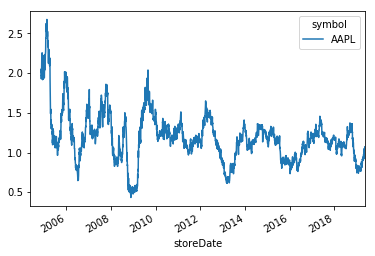

In [49]:
tech_ds.close_df[['AAPL']].apply(lambda x: (x.pct_change(120)+1)).plot()

In [90]:
%%time
rank_ks = (20, 60, 120, 250, 500)
hist_perf_ranks = {
    k: tech_ds.close_df[tech_ds.companies]\
    .apply(lambda x: (x.pct_change(k)+1))
    .apply(lambda x: x.rank(pct=True, ascending=True), axis=0)
 for k in rank_ks}

CPU times: user 7.31 s, sys: 93.3 ms, total: 7.41 s
Wall time: 7.41 s


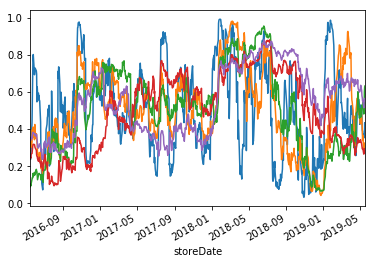

In [91]:
for x in rank_ks: hist_perf_ranks[x]['NFLX'].tail(252*3).plot()

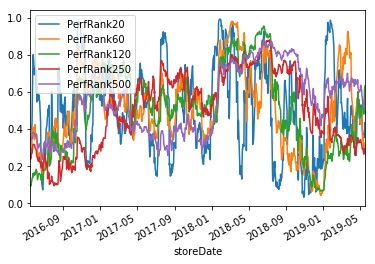

In [95]:
ndf = pd.DataFrame()
for k in rank_ks: ndf[f'PerfRank{k}'] = hist_perf_ranks[k]['NFLX']

#### Merge company and group features

In [692]:
%%time
# stitch all companies and group features
super_list = []
for t in tickers:
    # instrument features
    inst_df = technical_transforms(t, incl_name=False, incl_close=False)
    # group features
    symbol_list = []
    for key in incl_group_feat_dict.keys():
        if t in profile.index:
            df = incl_group_feat_dict[key][get_group_keys(t)]
            df.columns = [key + x for x in ['All', 'Sect', 'Ind']]
            symbol_list.append(df)
    for x in {
        'delta50': group_50deltas_df, 
        'detlta200': group_200deltas_df}.items():
        key, delta = x
        df = delta[t]
        df.columns = [key + x for x in ['All', 'Sect', 'Ind']]
        symbol_list.append(df)
    group_df = pd.concat(symbol_list, axis=1)
    symbol_df = pd.concat([inst_df, group_df], axis=1)
    symbol_df['symbol'] = t
    symbol_df.set_index('symbol', append=True, inplace=True)
    super_list.append(symbol_df)

combined_df = pd.concat(super_list, axis=0, sort=False)
print(combined_df.columns)
print(combined_df.shape)

Index(['PctChg1', 'PctChg20', 'PctChg50', 'PctChg200', 'PctChgStds1',
       'PctChgStds20', 'PctChgStds50', 'PctChgStds200', 'IntraDayChg',
       'OpenGap', 'Pct50MA', 'Pct200MA', 'Pct52WH', 'Pct52WL', 'PctVol10DA',
       'PctVol50DA', 'PctDV10DA', 'PctDV50DA', 'RollRealVol30', 'MaxDraw120',
       'MaxPull120', 'pctGt50MAAll', 'pctGt50MASect', 'pctGt50MAInd',
       'pctGt200MAAll', 'pctGt200MASect', 'pctGt200MAInd', 'pctPosStdsAll',
       'pctPosStdsSect', 'pctPosStdsInd', 'pctNegStdsAll', 'pctNegStdsSect',
       'pctNegStdsInd', '50StdsAll', '50StdsSect', '50StdsInd', '200StdsAll',
       '200StdsSect', '200StdsInd', 'delta50All', 'delta50Sect', 'delta50Ind',
       'detlta200All', 'detlta200Sect', 'detlta200Ind'],
      dtype='object')
(947776, 45)
CPU times: user 9.62 s, sys: 268 ms, total: 9.89 s
Wall time: 9.9 s


In [693]:
combined_df.tail()

,,PctChg1,PctChg20,PctChg50,PctChg200,PctChgStds1,PctChgStds20,PctChgStds50,PctChgStds200,IntraDayChg,OpenGap,...,50StdsInd,200StdsAll,200StdsSect,200StdsInd,delta50All,delta50Sect,delta50Ind,detlta200All,detlta200Sect,detlta200Ind
storeDate,symbol,,,,,,,,,,,,,,,,,,,,,
2019-05-13,TXRH,0.000911,-0.119231,-0.128725,-0.189141,0.0,-1.0,-0.0,-0.0,-0.011689,0.012748,...,0.0,-0.0,0.0,0.0,-0.131643,-0.147793,-0.189376,-0.177125,-0.196525,-0.345273
2019-05-14,TXRH,-0.004367,-0.105151,-0.119549,-0.190413,-0.0,-1.0,-0.0,-0.0,-0.003642,-0.000728,...,0.0,-0.0,0.0,0.0,-0.134445,-0.152046,-0.189602,-0.189345,-0.211741,-0.354545
2019-05-15,TXRH,-0.016447,-0.109530,-0.132075,-0.206897,-0.0,-1.0,-1.0,-0.0,-0.010662,-0.005848,...,0.0,0.0,0.0,0.0,-0.154053,-0.159999,-0.207014,-0.218299,-0.253700,-0.366838
2019-05-16,TXRH,-0.019509,-0.107710,-0.133498,-0.201543,-0.0,-1.0,-1.0,-0.0,-0.021872,0.002415,...,0.0,0.0,0.0,0.0,-0.171337,-0.171758,-0.215218,-0.227848,-0.278206,-0.373403
2019-05-17,TXRH,0.035816,-0.086717,-0.095632,-0.130172,1.0,-1.0,-0.0,-0.0,0.027251,0.008338,...,1.0,0.0,0.0,1.0,-0.135866,-0.137912,-0.195339,-0.145526,-0.185430,-0.318321


#### Data inspection, charts and tables

In [294]:
idx = pd.IndexSlice
px_vol_df.loc[:, idx[:, bench]].tail()

,high,low,open,close,volume
symbol,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
storeDate,,,,,
2019-05-13,2840.189941,2801.429932,2840.189941,2811.870117,3.894030e+09
2019-05-14,2852.540039,2820.120117,2820.120117,2834.409912,3.322720e+09
2019-05-15,2858.679932,2815.080078,2820.379883,2850.959961,3.125950e+09
2019-05-16,2892.149902,2855.800049,2855.800049,2876.320068,3.338060e+09
2019-05-17,2885.479980,2854.229980,2858.600098,2859.530029,1.887750e+09


In [295]:
idx = pd.IndexSlice
px_vol_df.loc[:, idx[:, symbol]].tail()

,high,low,open,close,volume
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
storeDate,,,,,
2019-05-13,189.479996,182.850006,187.710007,185.720001,57430600.0
2019-05-14,189.699997,185.410004,186.410004,188.660004,36529700.0
2019-05-15,191.750000,186.020004,186.270004,190.919998,26544700.0
2019-05-16,192.470001,188.839996,189.910004,190.080002,33012200.0
2019-05-17,190.889999,186.809998,186.929993,189.000000,29313720.0


In [296]:
# open, low, high, vol metrics
for df in (open_df, low_df, high_df, vol_df): print(df[symbol].tail())

storeDate
2019-05-13    187.710007
2019-05-14    186.410004
2019-05-15    186.270004
2019-05-16    189.910004
2019-05-17    186.929993
Name: AAPL, dtype: float32
storeDate
2019-05-13    182.850006
2019-05-14    185.410004
2019-05-15    186.020004
2019-05-16    188.839996
2019-05-17    186.809998
Name: AAPL, dtype: float32
storeDate
2019-05-13    189.479996
2019-05-14    189.699997
2019-05-15    191.750000
2019-05-16    192.470001
2019-05-17    190.889999
Name: AAPL, dtype: float32
storeDate
2019-05-13    57430600.0
2019-05-14    36529700.0
2019-05-15    26544700.0
2019-05-16    33012200.0
2019-05-17    29313720.0
Name: AAPL, dtype: float32


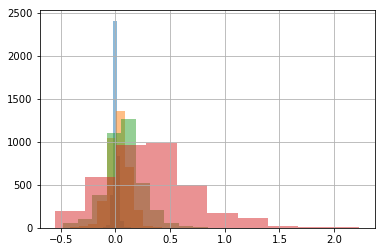

In [297]:
# close metrics
for x in pct_chg_keys: pct_chg_df_dict[x][symbol].hist(alpha=0.5)

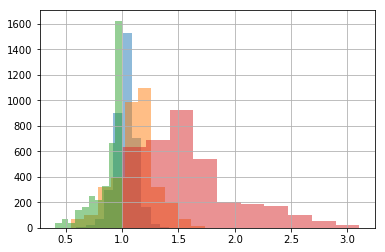

In [298]:
# price to moving averages
for df in (pct_50d_ma_df, pct_200d_ma_df, pct_52wh_df, pct_52wl_df): 
    df[symbol].hist(alpha=0.5)

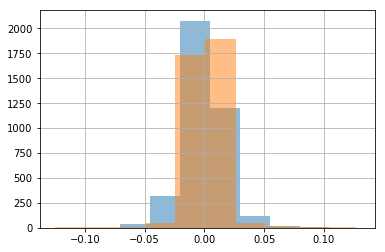

In [299]:
# intra day and open gaps
for df in (intra_day_chg_df, open_gap_df): 
    df[symbol].hist(alpha=0.5)

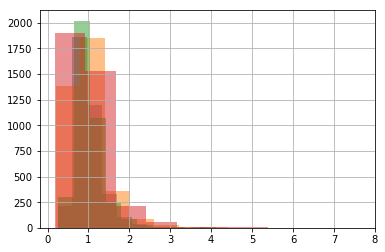

In [300]:
# volume and dollar value
for df in (pct_vol_10da_df, pct_vol_50da_df, pct_dv_10da_df, pct_dv_50da_df): 
    df[symbol].hist(alpha=0.5)

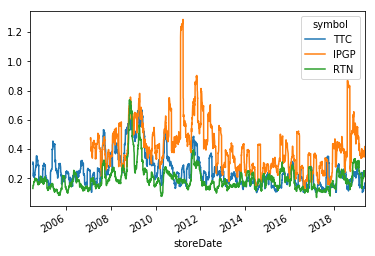

In [301]:
# realized volatility on sample set
roll_realvol_df[sample_symbols].plot();

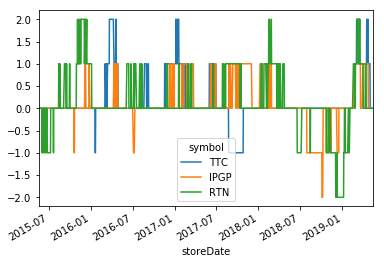

In [302]:
# statistically significant moves
pct_stds_df[sample_symbols].tail(252*4).plot()

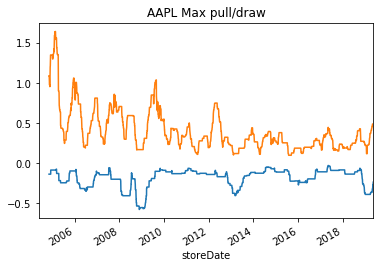

In [303]:
max_draw_df[symbol].plot()
max_pull_df[symbol].plot(title=f'{symbol} Max pull/draw');

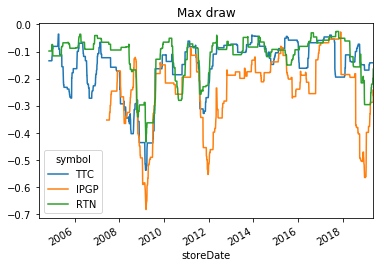

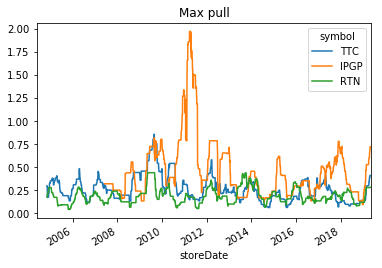

In [304]:
# historical max draws / pulls
max_draw_df[sample_symbols].plot(title='Max draw')
max_pull_df[sample_symbols].plot(title='Max pull')

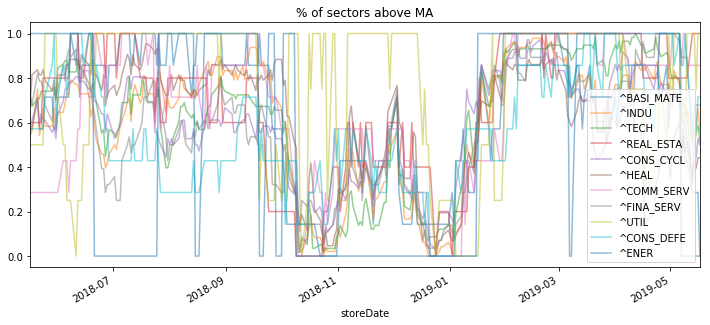

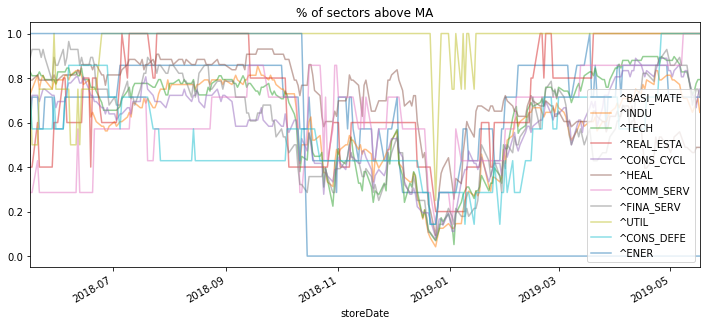

In [523]:
# see % of company above 200MA across sectors
for df in (pct_mt50ma_by_group_df, pct_mt200ma_by_group_df):
    df.tail(252)[sector_dict.keys()].plot(
        title='% of sectors above MA',
        figsize=(12,5), alpha=0.5);

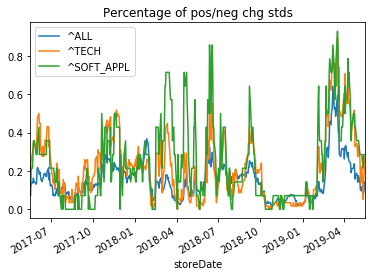

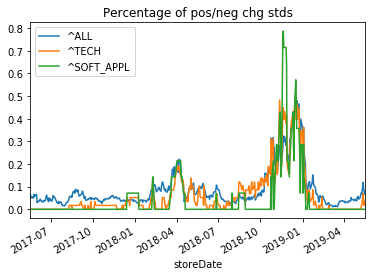

In [556]:
symbol = 'CRM'
for df in (pct_pos_stds_by_group_df, pct_neg_stds_by_group_df):
    df[get_group_keys(symbol)].tail(252*2).plot(title=f'Percentage of pos/neg chg stds');

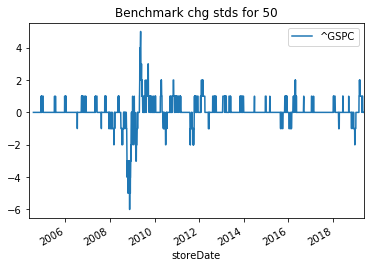

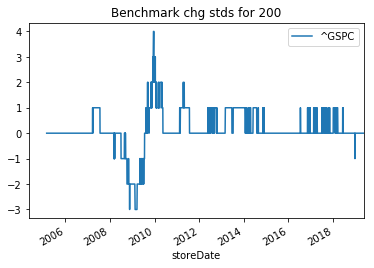

In [587]:
for key in bench_pct_stds_df.keys(): bench_pct_stds_df[key].plot(title=f'Benchmark chg stds for {key}');

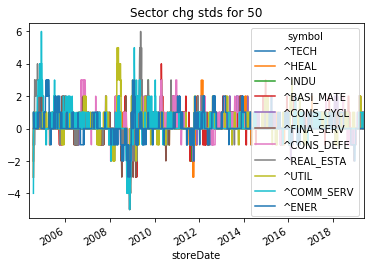

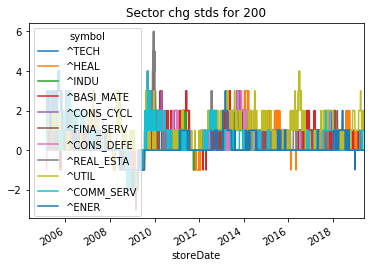

In [588]:
for key in sect_pct_stds_df.keys(): sect_pct_stds_df[key].plot(title=f'Sector chg stds for {key}');

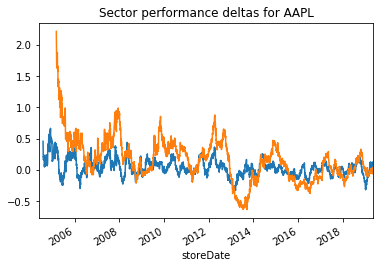

In [589]:
for key in sect_delta_dict.keys(): 
    sect_delta_dict[key][symbol].plot(title=f'Sector performance deltas for {symbol}');

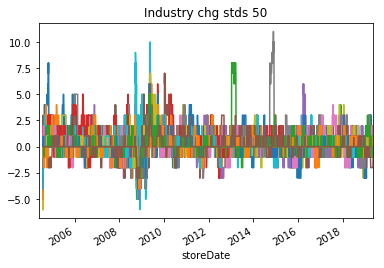

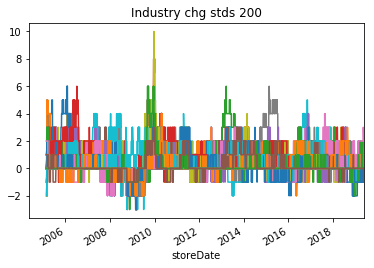

In [590]:
for key in ind_pct_stds_df.keys(): ind_pct_stds_df[key].plot(title=f'Industry chg stds {key}', legend=False);

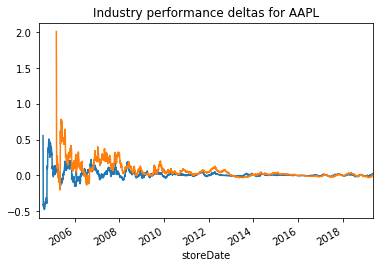

In [591]:
for key in ind_delta_dict.keys(): ind_delta_dict[key][symbol].plot(title=f'Industry performance deltas for {symbol}');

In [474]:
# how many other players in the same industry
symbol = 'AMZN'
profile.loc[profile.industry.isin([profile.loc[symbol, 'industry']]), ['longBusinessSummary']]

,longBusinessSummary
symbol,
AAP,"Advance Auto Parts, Inc. provides automotive r..."
AMZN,"Amazon.com, Inc. engages in the retail sale of..."
AZO,"AutoZone, Inc. retails and distributes automot..."
BABA,"Alibaba Group Holding Limited, through its sub..."
BBY,"Best Buy Co., Inc. operates as a retailer of t..."
DKS,"Dick's Sporting Goods, Inc. operates as a spor..."
EBAY,eBay Inc. operates commerce platforms connecti...
ETSY,"Etsy, Inc. operates Etsy.com, an online market..."
FIVE,"Five Below, Inc. operates as a specialty value..."


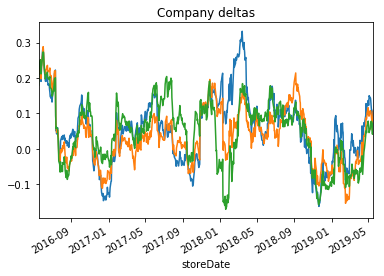

In [475]:
# once company relative performance to bench, sector, industry
period = 50; days = 252*3
for df in (bench_delta_dict, sect_delta_dict, ind_delta_dict):
    df[period]['AMZN'].tail(days).plot(title='Company deltas')

#### Max draw and pulls

Max draw: -0.08803194437193373, Max pull: 0.10238417993492877


(-0.08803194437193373, 0.10238417993492877)

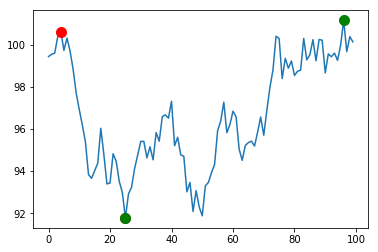

In [67]:
# Graph drawdowns and pulls
n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot([l_dd, h_dd], [r_w[l_dd], r_w[h_dd],], 'o', color='Red', markersize=10)
plt.plot([l_p, h_p], [r_w[l_p], r_w[h_p]], 'o', color='Green', markersize=10)

print(f'Max draw: {r_w[l_dd]/r_w[h_dd]-1}, Max pull: {r_w[h_p]/r_w[l_p]-1}')
max_draw(r_w), max_pull(r_w)

#### Visualize sectors and industry groups

In [764]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

from utils.pricing import discret_rets

best_perf_df = pd.concat([
    hist_return.reindex(index=tickers),
    profile.reindex(index=tickers, columns=['sector', 'industry']),
    quotes.reindex(index=tickers, columns=['marketCap'])], 
    axis=1, sort=False)

best_perf_df.loc[:, 'marketCap'] = best_perf_df.marketCap / 10**9
best_perf_df.loc[:, 'size'] = discret_rets(best_perf_df.marketCap, mkt_cap_cuts, mkt_cap_labels)

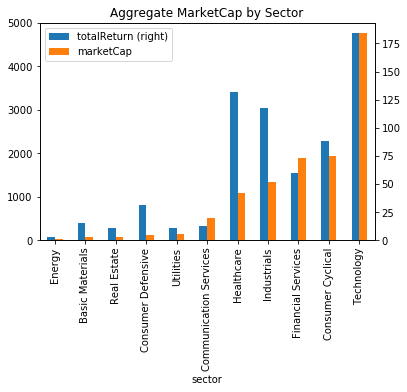

In [765]:
best_perf_df.groupby(by='sector').sum().sort_values('marketCap')\
    .plot(kind='bar', title='Aggregate MarketCap by Sector',
         secondary_y='totalReturn')

,sum,count
count,83.000000,83.000000
mean,143.666377,2.939759
std,298.581534,2.711086
min,1.733917,1.000000
25%,8.134525,1.000000
50%,35.520520,2.000000
75%,140.985196,4.000000
max,2145.230617,14.000000


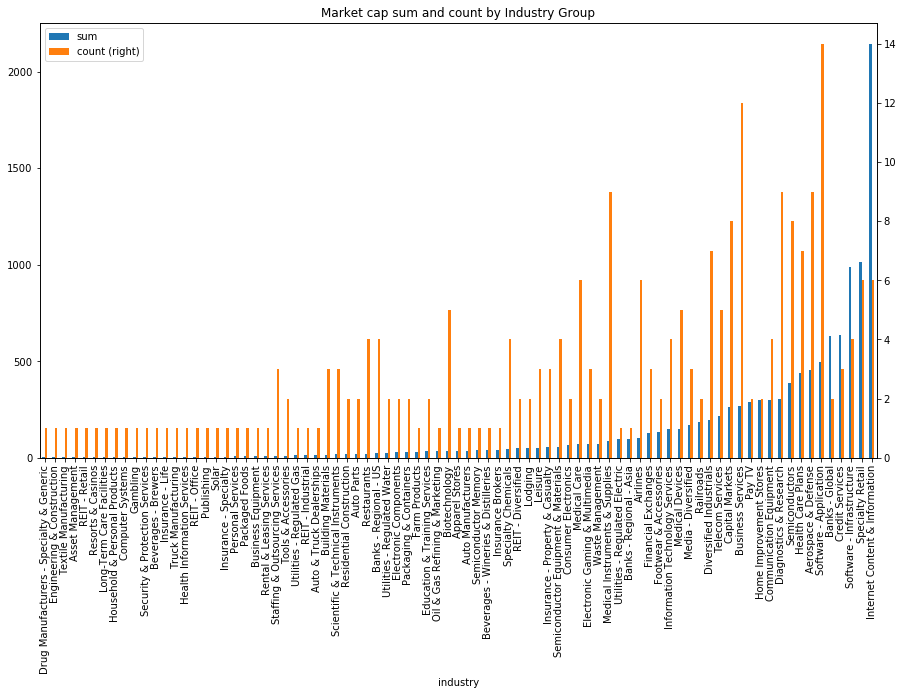

In [766]:
ind_group = best_perf_df.loc[tickers].groupby(by='industry')
sorting_df = ind_group.agg(['sum', 'count'])['marketCap'].sort_values(by='sum')
sorting_df.plot(
    kind='bar', figsize=(15,8), secondary_y='count', 
    title='Market cap sum and count by Industry Group')
sorting_df.describe()

In [774]:
best_perf_df.groupby(by=['sector', 'industry']).agg(['count', 'mean'])\
    .sort_values(by=('totalReturn', 'mean'), ascending=False).head(10)

totalReturn  \
                                                                  count   
sector             industry                                               
Consumer Defensive Education & Training Services                      2   
Technology         Computer Systems                                   1   
Consumer Cyclical  Media - Diversified                                3   
Industrials        Staffing & Outsourcing Services                    1   
Consumer Cyclical  Lodging                                            2   
Technology         Semiconductors                                     7   
Healthcare         Long-Term Care Facilities                          1   
                   Drug Manufacturers - Specialty & Generic           1   
Technology         Software - Infrastructure                          2   
Healthcare         Medical Care                                       5   

                                                                       \
                                                                 mean   
sector             industry                                             
Consumer Defensive Education & Training Services             9.586191   
Technology         Computer Systems                          7.613773   
Consumer Cyclical  Media - Diversified                       6.626868   
Industrials        Staffing & Outsourcing Services           6.208378   
Consumer Cyclical  Lodging                                   5.202275   
Technology         Semiconductors                            5.142485   
Healthcare         Long-Term Care Facilities                 4.965238   
                   Drug Manufacturers - Specialty & Generic  4.854013   
Technology         Software - Infrastructure                 4.663229   
Healthcare         Medical Care                              4.579359   

                                                            marketCap  \
                                                                count   
sector             industry                                             
Consumer Defensive Education & Training Services                    2   
Technology         Computer Systems                                 1   
Consumer Cyclical  Media - Diversified                              3   
Industrials        Staffing & Outsourcing Services                  3   
Consumer Cyclical  Lodging                                          2   
Technology         Semiconductors                                   8   
Healthcare         Long-Term Care Facilities                        1   
                   Drug Manufacturers - Specialty & Generic         1   
Technology         Software - Infrastructure                        4   
Healthcare         Medical Care                                     6   

                                                                         
                                                                   mean  
sector             industry                                              
Consumer Defensive Education & Training Services              16.820535  
Technology         Computer Systems                            3.529972  
Consumer Cyclical  Media - Diversified                        57.219389  
Industrials        Staffing & Outsourcing Services             3.377576  
Consumer Cyclical  Lodging                                    26.024709  
Technology         Semiconductors                             48.464257  
Healthcare         Long-Term Care Facilities                   3.002438  
                   Drug Manufacturers - Specialty & Generic    1.733917  
Technology         Software - Infrastructure                 247.097950  
Healthcare         Medical Care                               11.517127

#### Understand price changes across universe

In [317]:
sector_mapper = {
    s: list(size_df.loc[
            size_df.index.isin(tickers) 
            & (size_df.sector == 'Technology')].index)
    for s in tgt_sectors}

In [273]:
from utils.pricing import get_ind_index

tail = 90
Y = get_ind_index(px_close.dropna(subset=['^GSPC'])[tickers], tail=tail) - 1

In [274]:
indices_df = pd.concat(
    [eq_wgt_indices(profile, px_close, 'sector', tgt_sectors, subset=tickers, tail=tail),
    eq_wgt_indices(profile, px_close, 'industry', tgt_industries, subset=tickers, tail=tail),
    to_index_form(px_close[bench].tail(tail), bench)], axis=1).drop_duplicates() - 1

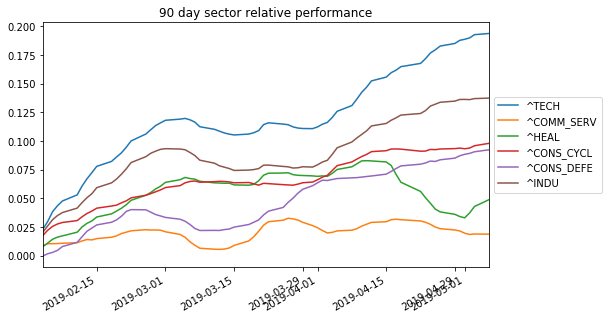

In [275]:
from utils.pricing import shorten_name

loc, margin = 'center left', (1, 0.5)

sect_idx = indices_df[[shorten_name(x) for x in tgt_sectors]].rolling(10).mean().dropna()
ax = sect_idx.plot(figsize=(8,5), title=f'{tail} day sector relative performance')
ax.legend(loc=loc, bbox_to_anchor=margin)

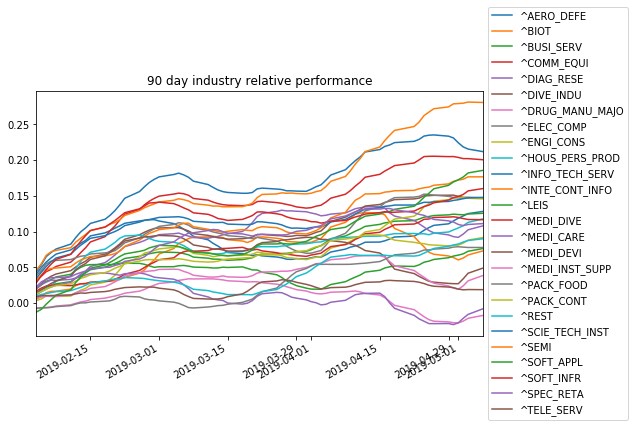

In [318]:
ind_idx = indices_df[
    [shorten_name(x) for x in tgt_industries]]\
    .rolling(10).mean().dropna()
ax = ind_idx.plot(figsize=(8,5), title=f'{tail} day industry relative performance')
ax.legend(loc=loc, bbox_to_anchor=margin)

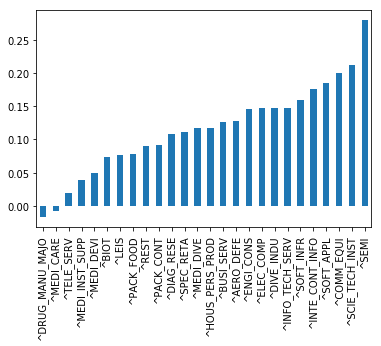

In [307]:
ind_idx.iloc[-1].sort_values().plot(kind='bar')

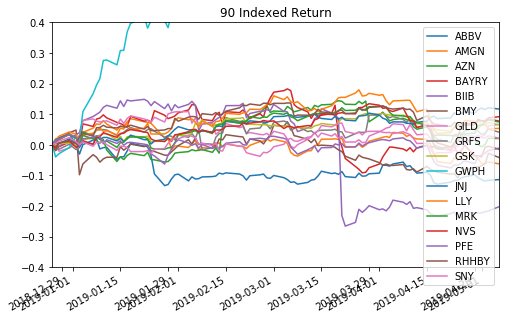

In [320]:
see_industry = 'Drug Manufacturers - Major'
see_tickers = list(size_df.loc[size_df.index.isin(tickers) & (size_df.industry == see_industry)].index)

Y[see_tickers].plot(
    figsize=(8,5), 
    title=f'{tail} Indexed Return',
    ylim=(-.4, 0.4))
ax.legend(loc=loc, bbox_to_anchor=margin)

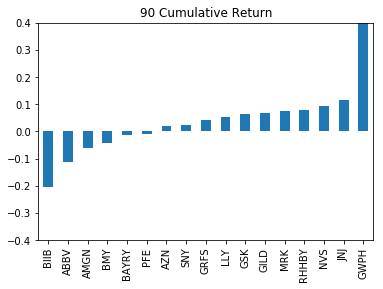

In [321]:
Y[see_tickers].iloc[-1].sort_values().plot(
    kind='bar',
    title=f'{tail} Cumulative Return',
    ylim=(-.4, 0.4))

#### Remove price outliers

In [ ]:
y_outliers = Y.loc[(Y > 1).any(1).values, (Y > 1).any().loc[(Y > 1).any()].index]
y_outliers.max().sort_values()

#### Old training

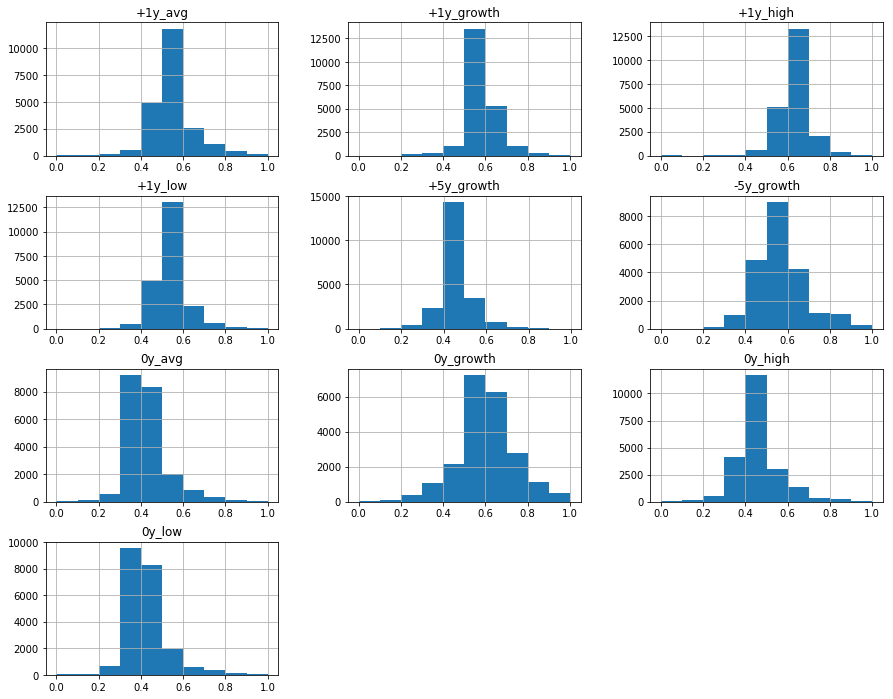

In [20]:
X_train.hist(figsize=(15,12));